# Image Classification using Transfer Learning
We will classify images of cats and dogs using transfer learning models such as Inception, ResNet and VGGNet. 

In [1]:
import tarfile
import urllib
import os
import time
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
   

# Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press Enter;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called sciml-workshop-data should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path + 'sciml-workshop/'
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

print(data_path)

/mnt/materials/SciML/sciml-workshop/


In [3]:
%%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

apt -qq update
apt -qq install s3fs fuse
mkdir -p $2
s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

Running notebook locally.


# Add label to each image

This is a data preprocessing step which ensures a proper label is added to each image name. 

In [4]:
def image_annotations(file_path):
    annotations = []
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        image_name += '.jpg'
        if image_name[0].lower() != image_name[0]:
            class_name = 'cat'
        else:
            class_name = 'dog'
        
        annotations.append((image_name, class_name))
    
    return annotations


num_classes = 2
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_path = os.path.join(data_path, 'sciml-workshop/transfer-data/annotations/trainval.txt')
test_path = os.path.join(data_path, 'sciml-workshop/transfer-data/annotations/test.txt')

train_annot = image_annotations(train_path)
test_annot = image_annotations(test_path)

print('Training examples count:', len(train_annot))
print('Test examples count:', len(test_annot))

Training examples count: 3680
Test examples count: 3669


# Create a Pytorch dataset for faster loading

We will create our custom dataset `SimpleDataset` that inherits Pytorch build in `Dataset` so we can effeciently load the images from the directory.  

In [7]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

image_dir = os.path.join(data_path, 'sciml-workshop/transfer-data/images')

# We need to standardize the images for consistency with pre-training
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

class SimpleDataset(Dataset):
    
    def __init__(self, data_dir, annotations, image_transform=None, target_transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.annotations = annotations
        self.image_transform = image_transform
        self.target_transform = target_transform

    def __len__(self, ):
        return len(self.annotations)
        
    def __getitem__(self, index):
        
        file, label = self.annotations[index]
        
        img = Image.open(os.path.join(self.data_dir, file)).convert('RGB')
        
        label = class_to_index[label]
        if self.image_transform is not None:
            img = self.image_transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

train_dataset = SimpleDataset(image_dir, train_annot, image_transform=image_transform)
test_dataset = SimpleDataset(image_dir, test_annot, image_transform=image_transform)

print("Number of training samples: %d" % len(train_dataset))
print("Number of test samples: %d" % len(test_dataset))

# Create dataloader to load the dataset during training
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Verify dataloader is working
x, y = next(iter(train_dataloader))

Number of training samples: 3680
Number of test samples: 3669


## Visualize images

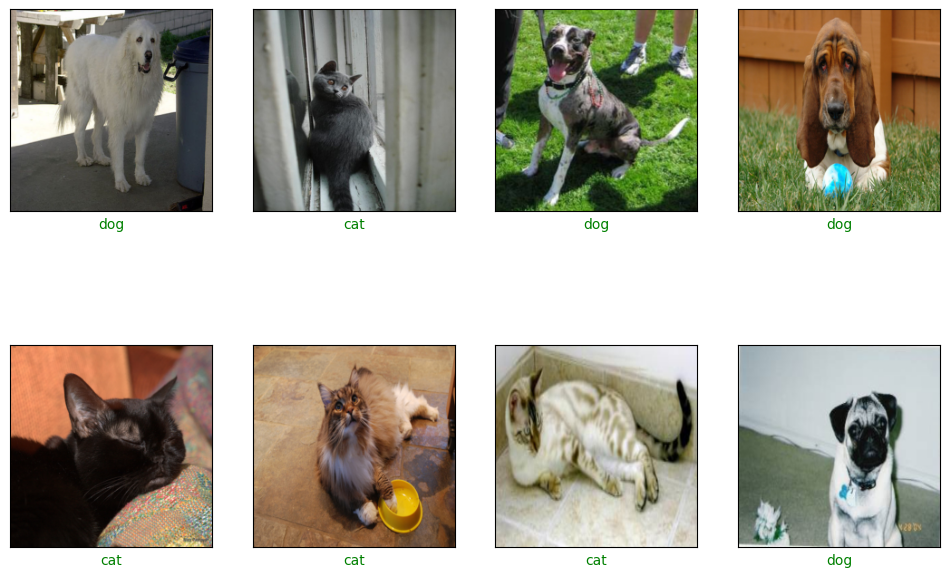

In [9]:
def unnormalize(x, mean=(0.485, 0.456, 0.406), std=[0.229, 0.224, 0.225]):
    
    mean = torch.tensor(mean).view(1,3,1,1)
    std = torch.tensor(std).view(1,3,1,1)

    return x.mul(std).add(mean)

def display_images(x, y, p, index_to_class):
    
    if len(x) < 8:
        print('Need at least 8 examples')
        return None

    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        gt = int(np.squeeze(y[i]) > 0.5)
        pred = int(np.squeeze(p[i]) > 0.5)
        col = 'green' if gt == pred else 'red'
        plt.xlabel(index_to_class[pred], color=col)
    return plt

display_images(unnormalize(x).permute(0, 2, 3, 1).numpy(), y, y, index_to_class).show()

# Load pre-trained model

Here we load a pre-trained model from torchvision. The model is specified using the variable model_name. 

In [11]:
from torchvision import models

MODELS = {
    'vgg': models.vgg16,
    'resnet': models.resnet50,
    # 'inception': models.inception_v3,
    'efficientnet': models.efficientnet_v2_s,
}

feature_dims = {
    'vgg': 512,
    'resnet': 2048,
    'efficientnet': 1280
}
    
# pretrained_model_name = 'resnet'
# pretrained_model = MODELS[pretrained_model_name](pretrained=True)
# print(pretrained_model)

# Build a classifier with pre-trained model as a backbone layer
Here we will use the pretrained image model trained on large datasets like `ImageNet` as a feature extraction layer. The backbone features are used to train a classifier to classify the features into `cat` and `dog`. The objective is to reduce the training time and the amount of data needed for this new task, as the pre-trained model already has a good understanding of basic patterns and features from the pre-trained task.

In [16]:
from torch import nn

class Classifier(nn.Module):
    def __init__(self, pretrained_model, num_features, output_layer='avgpool', output_dim=2, dropout=0.0):
        super().__init__()

        self.pretrained_model = pretrained_model
    
        self.num_features = num_features
        
        self.output_layer = output_layer
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Dropout(dropout),
            nn.Linear(num_features, output_dim),
            nn.Softmax()
        )
        
        # Freeze the  parameters of base model
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
    

    def forward(self, x):
        # Pass input through each layer
        for name, layer in self.pretrained_model._modules.items():
            x = layer(x)
            if name == self.output_layer:  # Save output of specific layer
                break  # Stop after the desired layer
                
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Train model
We will use the scripts written in [DNN_basics.ipynb](../DNN/DNN_basics.ipynb) for the training. Ensure that new instances of the model and optimizers are created, as reusing the previous states could lead to incorrect results.

Note! The training could be slightly slow due to large size of images

In [17]:
import time
import torch
from torch import nn
from torch.nn import functional as F

# define a train function
def train(dataloader, model, loss_fn, optimizer, device):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.classifier.train()
    
    train_loss, train_accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        # place tensors to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred_y = model(X)

        # convert target class indices into one-hot encoding
        target_y = F.one_hot(y, 2).to(torch.float32)

        # compute loss
        loss = loss_fn(pred_y, target_y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_accuracy += (pred_y.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.detach().item()
    
    train_loss /= num_batches
    train_accuracy /= size
    
    return train_loss, train_accuracy

# define a test function to evaluate the model
def test(dataloader, model, loss_fn, device):
    # set the model to eval mode
    model.classifier.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # inference/prediction
            pred_y = model(X)

            # convert target class indices into one-hot encoding
            target_y = F.one_hot(y, 2).to(torch.float32)
        
            # compute test loss and accuracy
            test_loss += loss_fn(pred_y, target_y).item()
            test_accuracy += (pred_y.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    test_accuracy /= size

    return test_loss, test_accuracy

def trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    
    start = time.time()
    
    h = dict(train_loss=[], test_loss=[], train_accuracy=[], test_accuracy=[])
    
    for t in range(epochs):
        print(f"\nEpoch {t+1}/{epochs}: ", end='')
        
        train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer, device)

        test_loss, test_accuracy = test(test_dataloader, model, loss_fn, device)
        print(f"train_loss: {train_loss:0.3f}, train_accuracy: {(100*train_accuracy):0.2f}%, test_accuracy: {(100*test_accuracy):0.2f}%")

        # print(f"Test Accuracy: {(100*test_accuracy):0.2f}%, Test Loss: {test_loss:0.3f}")

        h['train_loss'].append(train_loss)
        h['test_loss'].append(test_loss)
        h['train_accuracy'].append(train_accuracy)
        h['test_accuracy'].append(test_accuracy)

    print(f"Done in {time.time()-start:.3f}secs!")
    
    return h

epochs = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

pretrained_model_name = 'vgg'
pretrained_model = MODELS[pretrained_model_name](pretrained=True)
    
model = Classifier(pretrained_model, num_features=feature_dims[pretrained_model_name], output_dim=num_classes)
model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

history = trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device)

Classifier(
  (pretrained_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

# Make predictions

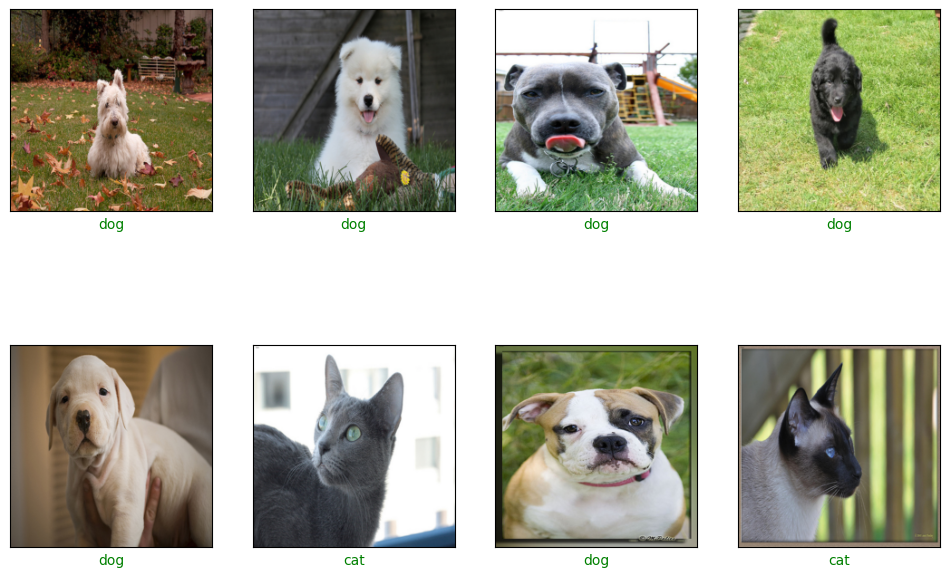

In [18]:
x, y = next(iter(test_dataloader))
with torch.no_grad():
    preds = model(x.to(device)).cpu().numpy()
    preds = preds.argmax(-1)

display_images(unnormalize(x).permute(0, 2, 3, 1).cpu().numpy(), y, preds, index_to_class).show()